In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import graycomatrix, graycoprops

# Region Based Segmentation

## What is Region Based Segmentation
- Region-based segmentation focuses on partitioning an image into regions that are similar according to certain characteristics such as intensity, color, or texture.
- This approach is often preferred in applications requiring precise delineation of objects, such as in medical imaging or object recognition.
- Perform better and more effective when objects have distinct boundaries and well-defined properties.

<center><img src="Region_based.png" width="500" height="250"><center>

## Region Growing

The **Region Growing** algorithm is a simple yet powerful approach to region-based segmentation. It starts with a seed point and grows the region by appending neighboring pixels that have similar properties to the seed. The growth continues until no more pixels meet the criteria for inclusion in the region. 

<center><img src="How_region_growing_image_segmentation_works-ezgif.com-crop.gif" width="400" height="400" alt="Description of image"><center>

The algorithm is defined by:
- **Seed Selection**: Choosing points from which to start growing the regions.
- **Growth Criteria**: Defining rules based on which neighboring pixels are added to the region (e.g., pixel intensity or color similarity).
- **Stopping Condition**: Determining when a region should stop growing, typically when there are no neighboring pixels that satisfy the growth criteria.

## General Steps
1. Scan the image sequentially! Find the first pixel that has not yet been assigned, and set the pixel to $(x_0, y_0)$.
2. Taking $(x_0, y_0)$ as the center, consider the 4 neighborhood pixels $(x, y)$ of $(x_0, y_0)$. If $(x_0, y_0)$ satisfies the growth criterion, merge $(x, y)$ with $(x_0, y_0)$ (in the same area), while pushing $(x, y)$ onto the stack.
3. Take a pixel from the stack, treat it as $(x_0, y_0)$ and return to step 2.
4. When the stack is empty! Return to step 1.
5. Repeat steps 1 - 4 until every point in the image is assigned. Growth is over.

## Different Growth Criteria

Choosing the right growth criteria is essential for the effectiveness of the Region Growing algorithm. 

So, what is a good growth criteria?

## It really depends on your task!

## 1. Intensity Similarity
- The most straightforward and commonly used criterion is intensity similarity. 
- A region grows by incorporating neighboring pixels that have similar intensity values to the  region's mean intensity. 
- This method is particularly useful in grayscale images where the variation in intensity is a strong indicator of different structures or objects.
    

## 2. Color Consistency
- In color images, the similarity in color can be used as a criterion. 
- This involves comparing the color values (in RGB, HSV, or another color space) of neighboring pixels to the average color of the region. 
- Regions grow by including pixels with color values within a specified threshold of the region's average color.

## 3. Texture Matching
- Texture is another important criterion, especially in images where texture provides more discriminative information than color or intensity alone. 
- This criterion may involve the use of texture descriptors such as gray level co-occurrence matrix (GLCM), or others to evaluate the similarity of texture in the region and its neighboring pixels.

## GLCM (Gray Level Co-occurrence Matrix)
A GLCM is a matrix where the number of rows and columns is equal to the number of gray levels, G, in the image.

The Gray Level Co-occurrence Matrix (GLCM) is defined as:

$
P_{\Delta x, \Delta y}(i, j) = \frac{1}{N} \sum_{x, y} \begin{cases} 
1 & \text{if } I(x, y) = i \text{ and } I(x+\Delta x, y+\Delta y) = j \\
0 & \text{otherwise}
\end{cases}
$

where $ N $ is the normalization factor, $ I(x, y) $ is the intensity of the pixel at position $ (x, y) $, and $ \Delta x $, $ \Delta y $ are the pixel displacements in the horizontal and vertical directions respectively.


## Features from GLCM
- $
Contrast = \sum_{i,j=0}^{G-1} (i - j)^2 P(i, j) 
$ (Measures the local variations in the GLCM matrix)

- $
Correlation = \sum_{i,j=0}^{G-1} \frac{(i - \mu_i)(j - \mu_j)P(i, j)}{\sigma_i \sigma_j}
$
where $ \mu_i $, $ \mu_j $ are the means and $ \sigma_i $, $ \sigma_j $ are the standard deviations of the row and column sums of \( P \), respectively. (Measures how correlated a pixel is to its neighbor over the whole image)

- $
Homogeneity = \sum_{i,j=0}^{G-1} \frac{P(i, j)}{1 + |i - j|}
$ (Measures the closeness of the distribution of elements in GLCM to the GLCM diagonal)

## 4. Gradient Threshold
- This criterion uses the image gradient to guide the region growth. 
- A common approach is to include neighboring pixels into a region if the edge strength (as measured by the gradient magnitude) between the pixel and the region is below a certain threshold, indicating that no strong boundary exists.

# Implementation with Intensity Similarity

Seed coordinate: (550, 550)


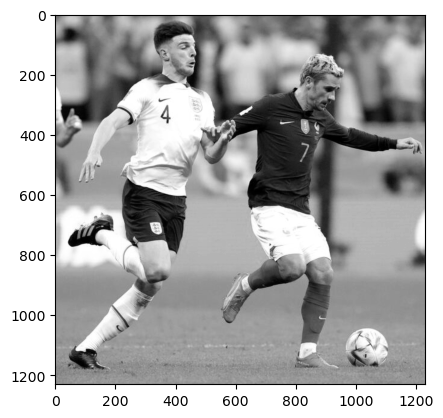

In [ ]:
image = cv2.imread('kane_rice_griez.png', cv2.IMREAD_GRAYSCALE)
arr = np.asarray(image)
plt.figure()
plt.imshow(image)
plt.gray()

x,y = 550, 550
seed_pixel = (x, y)

print ('Seed coordinate:',seed_pixel)

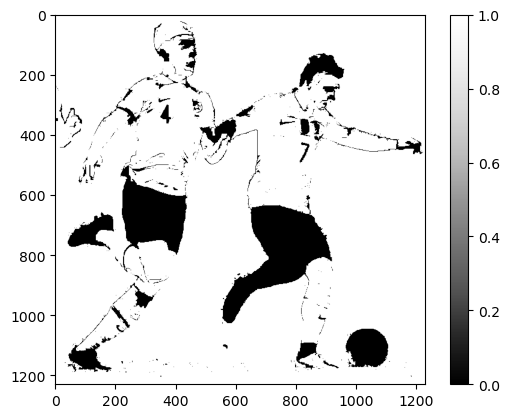

In [ ]:
def region_growing(image, seed, threshold):
    rows, cols = image.shape
    region = np.zeros_like(image, dtype=bool)
    candidates = [seed]
    while candidates:
        x, y = candidates.pop(0)
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  
            nx, ny = x + dx, y + dy
            # Ensure the neighbor is within image bounds and hasn't been added to the region
            if 0 <= nx < rows and 0 <= ny < cols and not region[nx, ny]:
                # Check if the neighbor's intensity is within the threshold of the current point
                if  arr[nx][ny] > arr[x][y] - threshold and arr[nx][ny] < arr[x][y] + threshold:
                    region[nx, ny] = True
                    candidates.append((nx, ny))
    return region

region = region_growing(image, seed_pixel, 12)
plt.figure()
plt.imshow(region, cmap="Greys_r")
plt.colorbar()
plt.show()


## Implementation with Texture Matching

Seed coordinate: (300, 300)


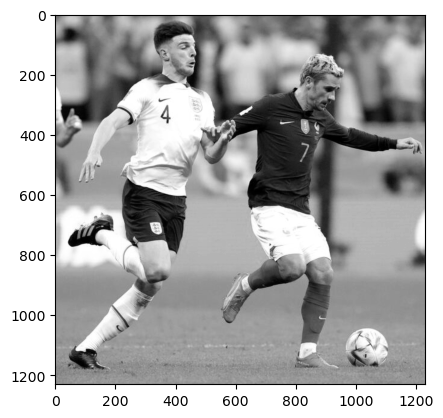

In [ ]:
image = cv2.imread('kane_rice_griez.png', cv2.IMREAD_GRAYSCALE)
arr = np.asarray(image)
rows, columns = np.shape(arr)
plt.figure()
plt.imshow(image)
plt.gray()

x,y = 300, 300
seed_pixel = (x, y)

print ('Seed coordinate:',seed_pixel)

In [ ]:
def texture_feature(image, x, y, window_size=5):
    # Calculate the half size of the window to use for creating a sub-image
    half_window = window_size // 2
    
    # Extract a sub-image around the (x, y) coordinate with the specified window size
    # Ensure the sub-image does not exceed the image boundaries
    sub_img = image[max(0, x-half_window):min(rows, x+half_window+1),
                    max(0, y-half_window):min(columns, y+half_window+1)]
    
    # Compute the Gray-Level Co-occurrence Matrix (GLCM) for the sub-image
    # GLCM is used to measure the texture of the sub-image
    glcm = graycomatrix(sub_img, [1], [0], 256, symmetric=True, normed=True)
    
    # Calculate the contrast from the GLCM, which is a measure of the intensity contrast between a pixel and its neighbor
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    return contrast

seed_texture = texture_feature(arr, x, y)

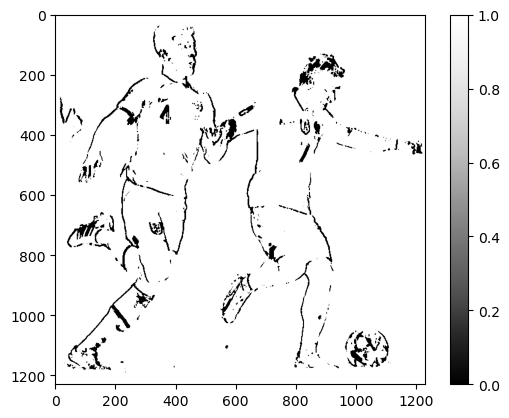

In [ ]:
def region_growing(image, seed):
    rows, cols = image.shape
    region = np.zeros_like(image, dtype=bool)
    candidates = [seed]
    texture_cache = {}
    while candidates:
        x, y = candidates.pop(0)
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  
            nx, ny = x + dx, y + dy
            if 0 <= nx < rows and 0 <= ny < cols and not region[nx, ny]:
                if (nx, ny) not in texture_cache:  # Calculate texture feature only if not in cache
                    texture_cache[(nx, ny)] = texture_feature(arr, nx, ny)
                texture = texture_cache[(nx, ny)]
                if abs(texture - seed_texture) < 200:
                    region[nx, ny] = True
                    candidates.append((nx, ny))
    return region

region = region_growing(arr, seed_pixel)

plt.figure()
plt.imshow(region, cmap="Greys_r")
plt.colorbar()
plt.show()

## Implementation with Gradient Threshold
Utilize Sobel operator to calculate the gradient magnitude of the image intensity, which gives the rate of change in brightness at each point in the image.

In [ ]:
image = cv2.imread('kane_rice_griez.png', cv2.IMREAD_GRAYSCALE)
seed_pixel = (550, 550)  
print ('Seed coordinate:',seed_pixel)

def calculate_gradient(image):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    gradient = np.sqrt(sobelx**2 + sobely**2)
    return gradient

gradient = calculate_gradient(image)

Seed coordinate: (550, 550)


In [ ]:
def region_growing(image, seed, threshold):
    rows, cols = image.shape
    region = np.zeros_like(image, dtype=bool)
    candidates = [seed]
    while candidates:
        x, y = candidates.pop(0)
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  
            nx, ny = x + dx, y + dy
            if 0 <= nx < rows and 0 <= ny < cols and not region[nx, ny]:
                if gradient[nx, ny] < threshold:
                    region[nx, ny] = True
                    candidates.append((nx, ny))
    return region

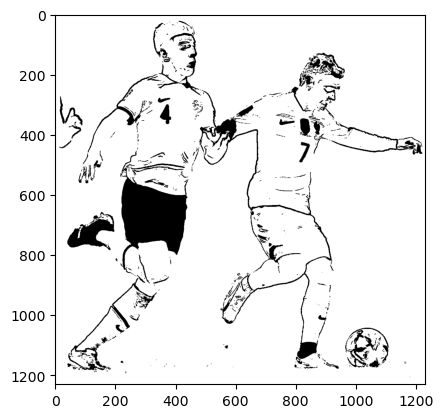

In [ ]:
threshold = 1500  
region = region_growing(image, seed_pixel, threshold)

plt.imshow(region, cmap='gray')
plt.show()

## Region Splitting and Merging

Contrary to the Region Growing algorithm, the **Region Splitting and Merging** technique involves a more complex process that can both split and merge regions based on a set of rules. The algorithm involves:

- **Region Splitting**: Dividing an image into quadrants recursively until each quadrant meets a criterion. 
- **Region Merging**: Assessing adjacent regions and merging them if the merger results in a region that meets the criteria.

This algorithm is effective for handling large images with varying characteristics across different regions. It is often applied in scenarios where different segments of the image have distinct statistical properties or when a global thresholding method is not sufficient.

## General Step
1. Split into four disjoint quadrants any region $R_i$ for which $Q(R_i) = \text{FALSE}$
2. When no further splitting is possible, merge any adjacent regions $R_j$ and $R_k$ for which $Q(R_j \cup R_k) = \text{TRUE}$
3. Stop when no further merging is possible.

<center><img src="Quadtree.png" width="600" height="300" alt="Description of image"><center>

In [ ]:
def check(img, h0, w0, h, w):
    area = img[h0:h0+h, w0:w0+w]
    mean = np.mean(area)
    std = np.std(area, ddof=1)
    
    # Initialize counters for total points and points that meet the condition
    total_points = 0
    operated_points = 0
    for i in range(h):
        for j in range(w):
            # Check if the pixel value is within two standard deviations of the mean
            if abs(area[i, j] - mean) < 2 * std:
                # Increment if within the acceptable range
                operated_points += 1
            total_points += 1
    # Return True if 95% or more of the points meet the condition, else False
    return operated_points / total_points >= 0.95

In [ ]:
def merge(img, h0, w0, h, w):
    for row in range(h0, h0 + h):
        for col in range(w0, w0 + w):
            # Check if the pixel value is between 100 and 200
            if 100 < img[row, col] < 200:
                # Set the pixel value to 0 (black) if within the range
                img[row, col] = 0
            else:
                # Set the pixel value to 255 (white) if outside the range
                img[row, col] = 255

In [ ]:
def split_merge(img, h0, w0, h, w):
    # Check if the size of square is greater than 5x5 and is not uniform
    if h > 5 and w > 5 and not check(img, h0, w0, h, w):
        new_h, new_w = h // 2, w // 2
        split_merge(img, h0, w0, new_h, new_w)  # Top-left
        split_merge(img, h0, w0 + new_w, new_h, w - new_w)  # Top-right
        split_merge(img, h0 + new_h, w0, h - new_h, new_w)  # Bottom-left
        split_merge(img, h0 + new_h, w0 + new_w, h - new_h, w - new_w)  # Bottom-right
    else:
        # If not splittable then merge
        merge(img, h0, w0, h, w)

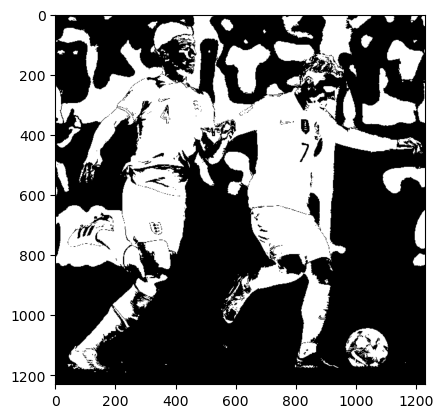

In [ ]:
img = cv2.imread('kane_rice_griez.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
segmented_img = img_gray.copy()
split_merge(segmented_img, 0, 0, segmented_img.shape[0], segmented_img.shape[1])

plt.imshow(segmented_img, cmap='gray')
plt.show()

# Application
Article **Enhanced Region Growing for Brain Tumor MR Image Segmentation** proposed an enhanced Region Growing approach to find out brain tumor from X-ray images.


## Improvements

- Traditional region-growing algorithms rely heavily on the manual or semi-manual initialization of seed points, which is **inconsistent**.
- The enhanced algorithm proposed in this article automates the seed point initialization, improves **consistency** and **accuracy**.

**Flowchart of the proposed algorithm**

<center><img src="Application.png" width="500" height="500" alt="Description of image"><center>
    
- Utilize Otsu’s thresholding technique to do the skull stripping.


**Sudo code for the proposed algorithm**

<center><img src="Sudo_Code.png" width="500" height="350" alt="Description of image"><center>
    
**Note**: In the dataset, the ground truth (GT) was included for training the segmentation model and qualitative evaluation.


**Enhanced Region Growing for Brain Tumor MR Image Segmentation**

<center><img src="Skull_Stripped.png" width="600" height="400" alt="Description of image"><center>

**Enhanced Region Growing for Brain Tumor MR Image Segmentation**

<center><img src="Annotated.png" width="600" height="400" alt="Description of image"><center>

**Enhanced Region Growing for Brain Tumor MR Image Segmentation**

<center><img src="Performance.png" width="700" height="75" alt="Description of image"><center>

**Note**: MAKM (Modified Adaptive K-Means)

## Reference
Biratu ES, Schwenker F, Debelee TG, Kebede SR, Negera WG, Molla HT. Enhanced Region Growing for Brain Tumor MR Image Segmentation. J Imaging. 2021 Feb 1;7(2):22. doi: 10.3390/jimaging7020022. PMID: 34460621; PMCID: PMC8321280.